In [87]:
%load_ext autoreload
%autoreload 2

from itertools import product
import sys
sys.path.append('/home/projects/nyosef/zvise/PixelGen/')
from PixelGen.multimodalvi import MultiModalSCVI
from PixelGen.multimodalvae import MultiModalVAE, AggMethod, D
from PixelGen.enums import AggMethod, D
from PixelGen.metrics import MultiModalVIMetrics
from sklearn.preprocessing import PowerTransformer
from pathlib import Path


import anndata as ad
import pixelator
import torch
import scvi
import scipy
# from scvi import autotune

import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

# import ray
# from ray import tune


from PixelGen.pxl_utils import train_model, get_model_latents
from PixelGen.scvi_utils import plot_losses, pca_neighbors_umap, calc_PCA
from pixelator.common.statistics import clr_transformation, dsb_normalize


from pixelator.pna.plot import molecule_rank_plot
# from pixelator.plot import molecule_rank_plot, cell_count_plot, scatter_umi_per_upia_vs_tau
# from pixelator.statistics import c
# lr_transformation
# from pixelator.analysis.normalization import dsb_normalize


from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from PixelGen.pxl_utils import train_model, get_model_latents, convert_polarization_to_feature_matrix, \
     convert_colocalization_to_feature_matrix, download_pxl
from PixelGen.scvi_utils import plot_losses, pca_neighbors_umap, calc_PCA, add_one_hot_encoding_obsm, plot_cumulative_variance
from PixelGen.common_utils import standardize, std_clip, filter_hv, split_pair_column, filter_df_by_two_columns, rank_plot
from PixelGen.metrics import MultiModalVIMetrics, distr_autocorrelation_in_latent
from PixelGen.multimodalvi import MultiModalSCVI
from PixelGen.multimodalvae import MultiModalVAE, AggMethod, D
from PixelGen.enums import AggMethod, D

import tempfile

from scvi import REGISTRY_KEYS
from scvi.module.base import (
    BaseModuleClass,
    LossOutput,
    PyroBaseModuleClass,
    auto_move_data,
)
from torch.distributions import NegativeBinomial, Normal, Poisson, MixtureSameFamily, Beta
from torch.distributions import kl_divergence as kl



# from cytovi import CytoVI

print(torch.cuda.is_available())
from sklearn.decomposition import PCA

from anndata import AnnData
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.set_figure_params(figsize=(6, 6), frameon=False)

sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

from utils import plot_latent, plot_gene_heatmap, plot_model_latents,get_dense,calculate_metrics,plot_composite_ppc
%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"


Seed set to 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True
Last run with scvi-tools version: 1.3.3


In [88]:
adata=sc.read_h5ad('/home/projects/nyosef/zvise/PixelGen/PixelGen/Data/adatas/final_adatas/adata_all_latents.h5ad')

# LATENT  RAW ABUNDANCE

In [137]:
adata.obsm['log1p']=adata.layers['log1p']

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, use_rep='log1p')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.8)



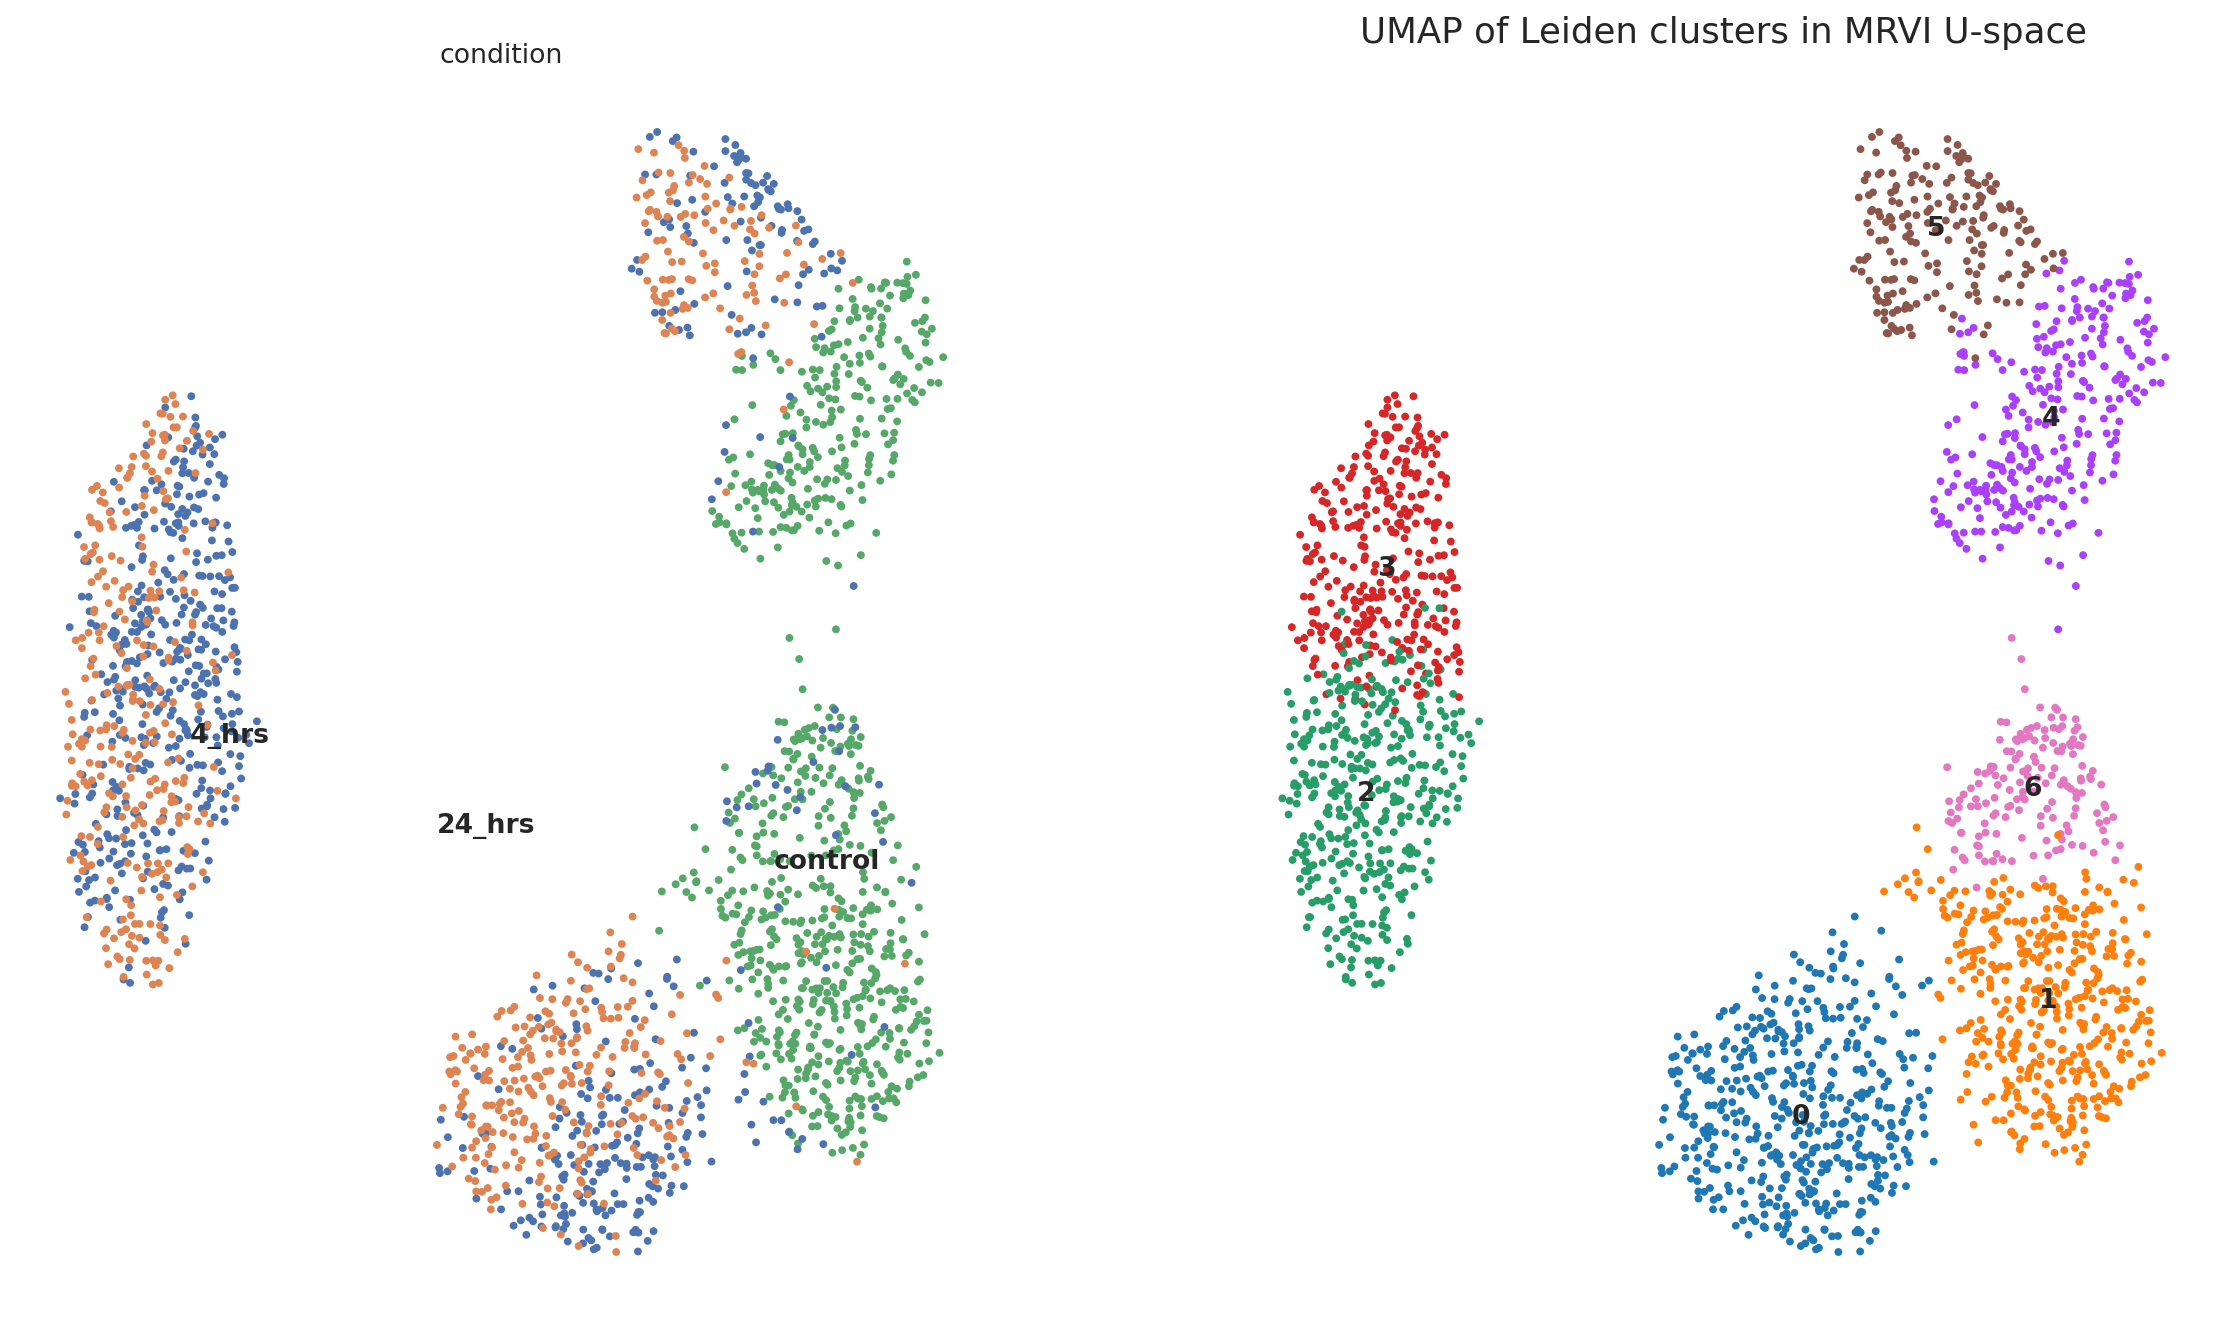

In [138]:
sc.pl.umap(adata, color=["condition",'leiden'], legend_loc='on data',frameon=False, size=50, show=False)
plt.gcf().set_size_inches(18, 10)
plt.title("UMAP of Leiden clusters in MRVI U-space", fontsize=16, pad=15)
plt.show()

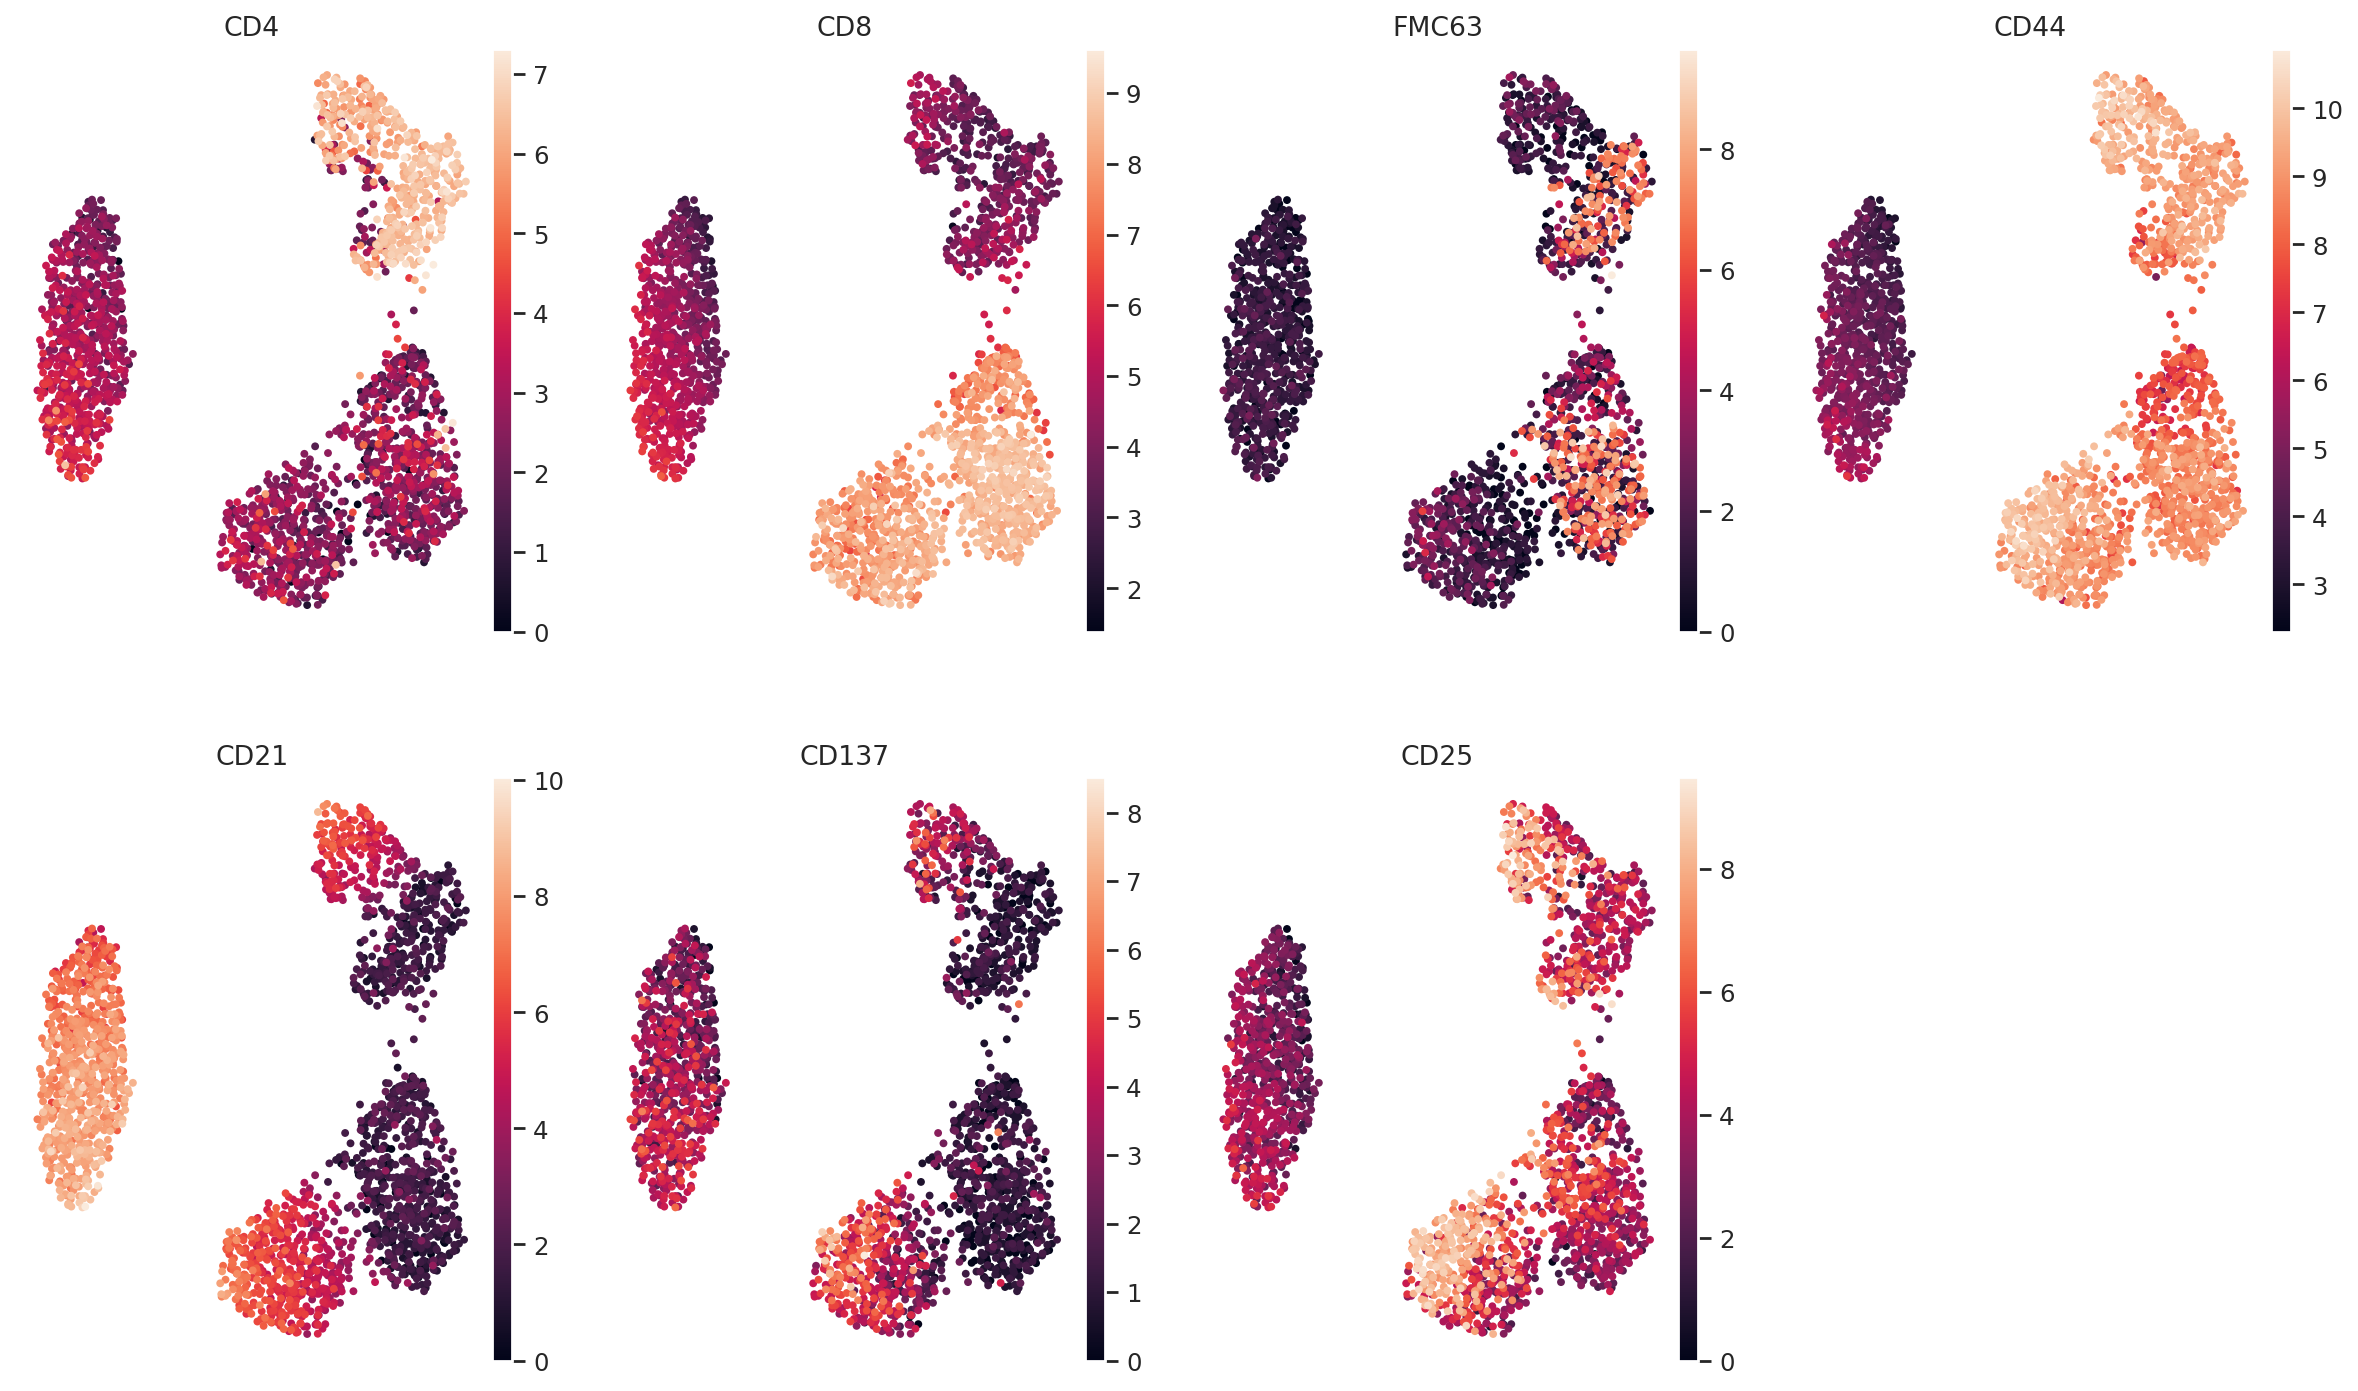

In [140]:
rel_genes=['CD4','CD8','FMC63','CD44','CD21','CD137','CD25']

sc.pl.umap(adata, color=rel_genes, frameon=False, size=50, show=False,layer='log1p')
plt.gcf().set_size_inches(18, 10)
plt.show()

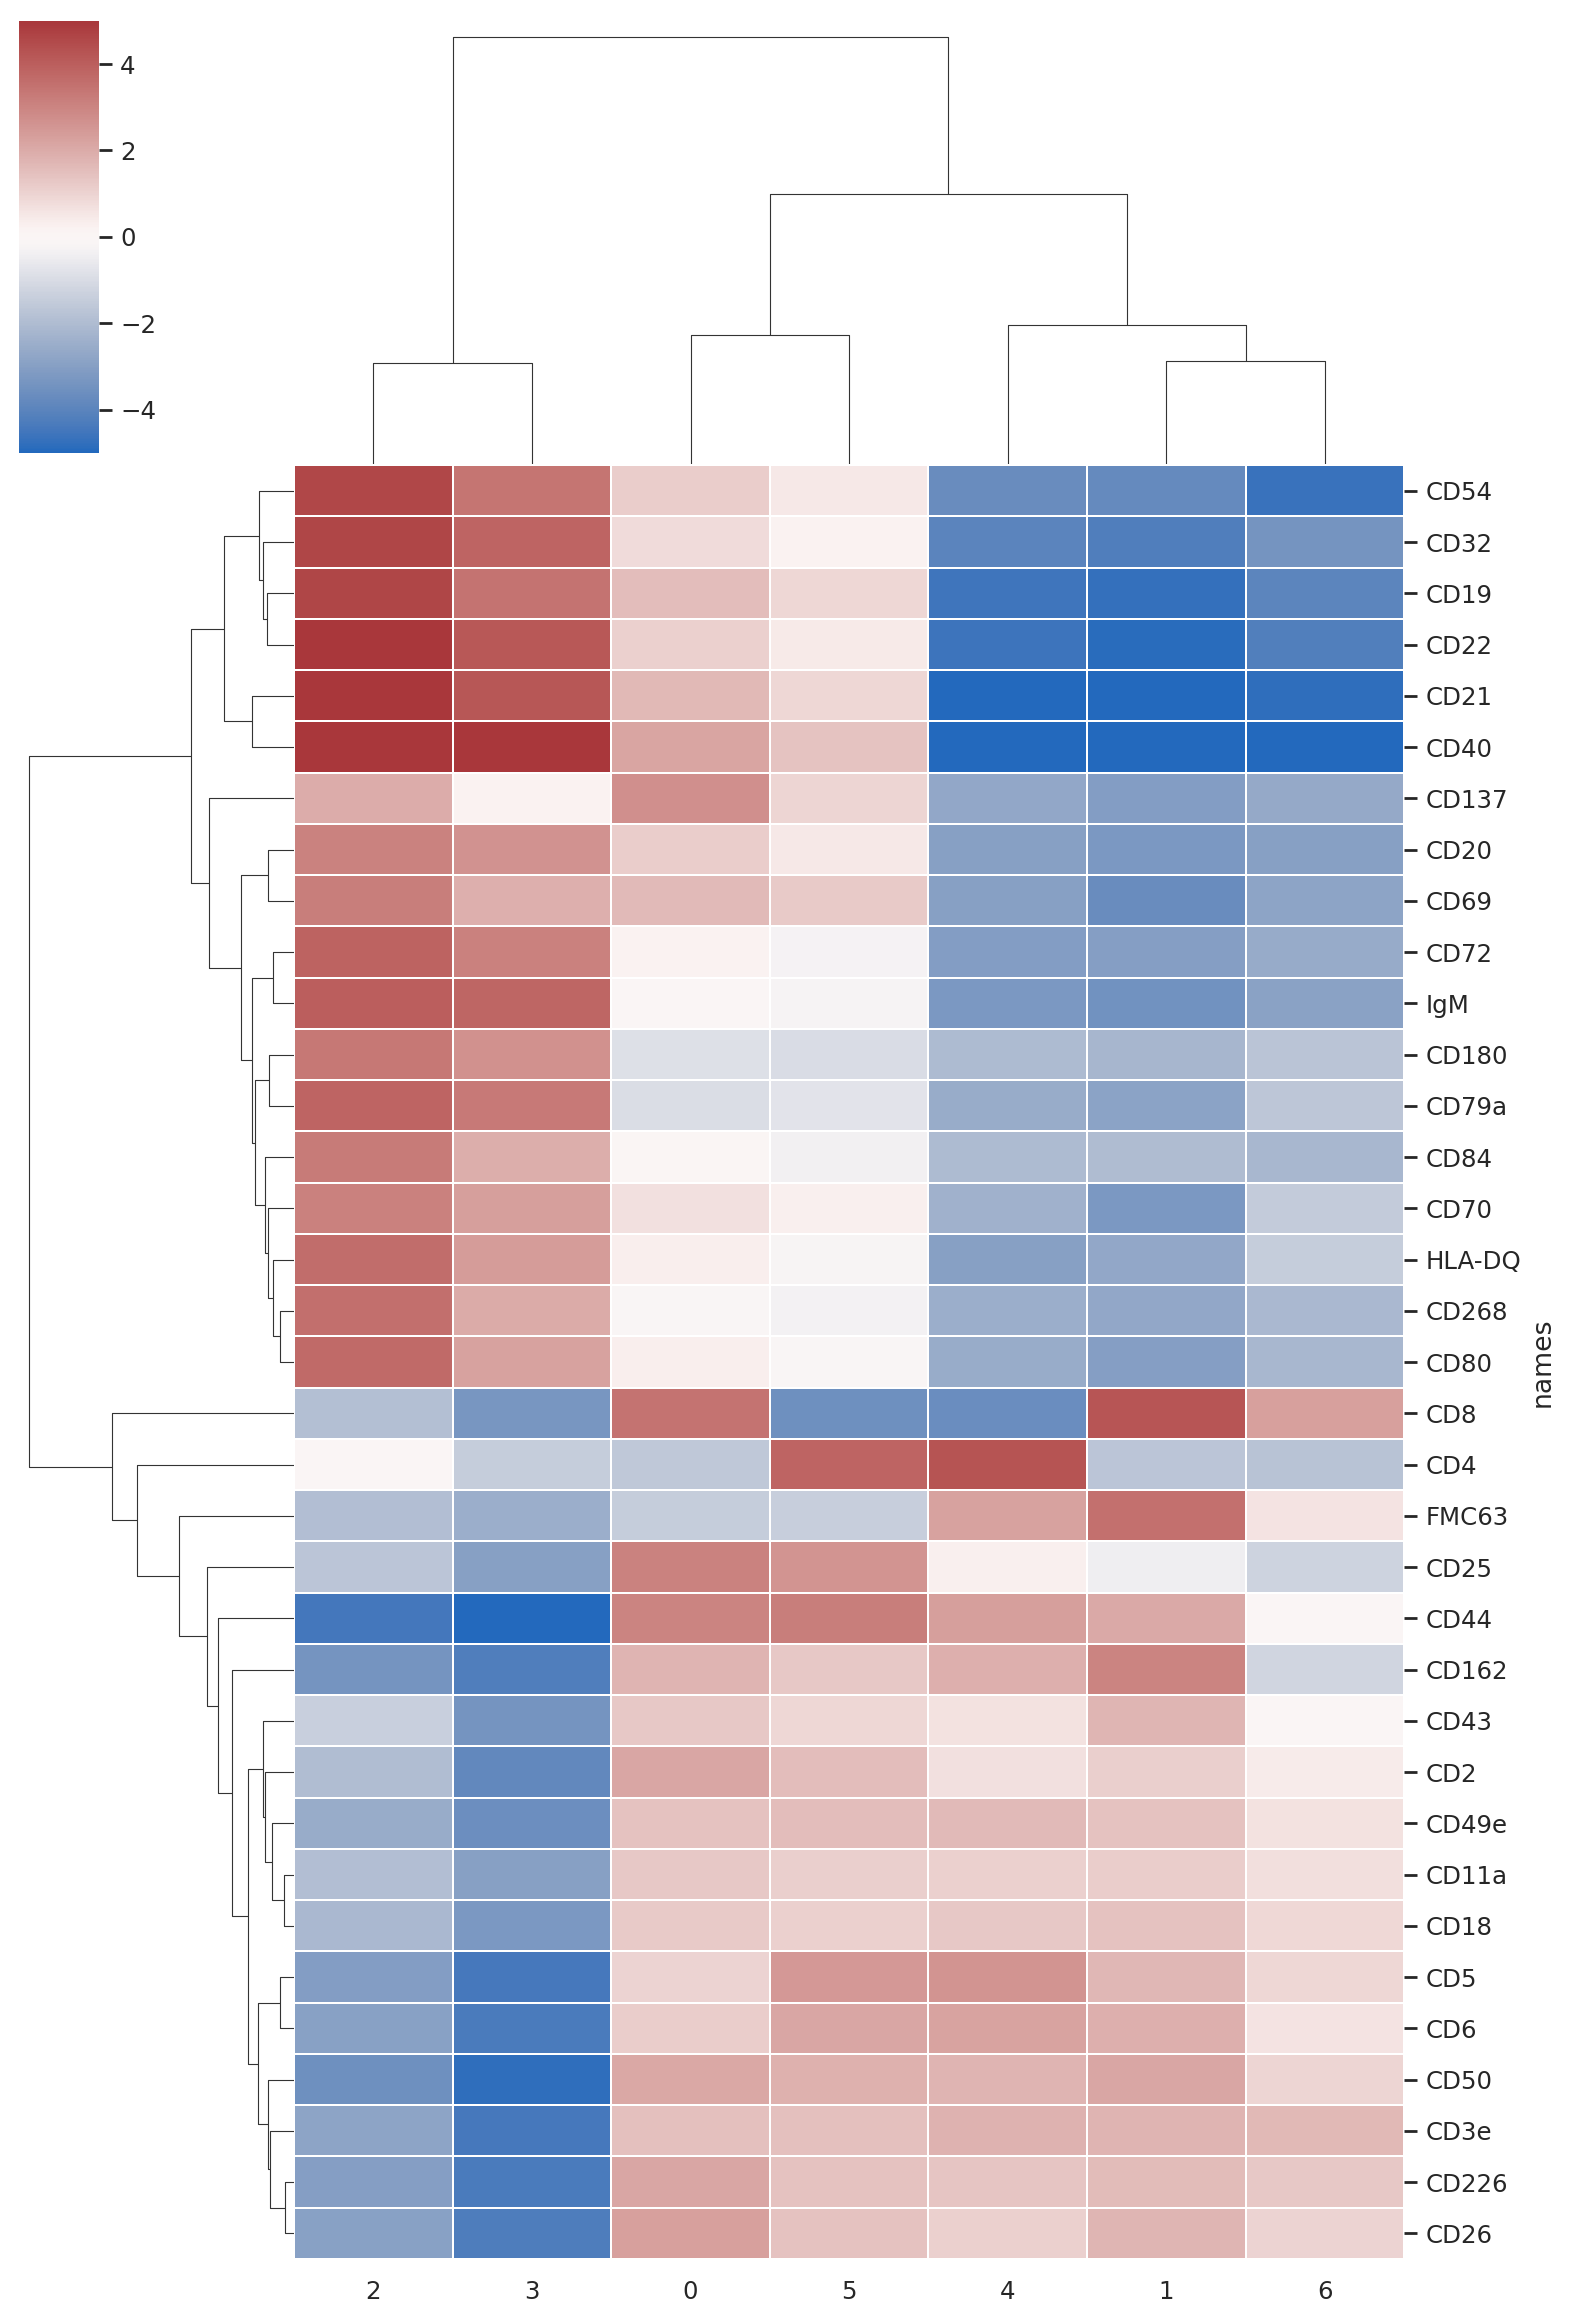

In [128]:
adata_tmp = ad.AnnData(
    X=adata.layers['log1p'],
    obs=adata.obs.copy(), var=adata.var.copy()
)
sc.tl.rank_genes_groups(adata_tmp,'leiden', method="wilcoxon",)


diff_exp_df = sc.get.rank_genes_groups_df(adata_tmp, group=None)
diff_exp_df["-log10(adjusted p-value)"] = -np.log10(diff_exp_df["pvals_adj"])
diff_exp_df["Significant"] = diff_exp_df["pvals_adj"] < 0.01
df = diff_exp_df.pivot(index=["names"], columns=["group"], values=["logfoldchanges"])

markers_for_heatmap = set(
    diff_exp_df[
        (np.abs(diff_exp_df["logfoldchanges"]) > 3) & diff_exp_df["Significant"]
    ]["names"]
)
markers_to_add=[]

markers_for_heatmap.update(markers_to_add)

df = df[df.index.isin(markers_for_heatmap)]

df.columns = [cluster for _, cluster in df.columns]
fig = sns.clustermap(df, yticklabels=True, linewidths=0.1, cmap="vlag", vmin=-5, vmax=5);
fig.fig.set_size_inches(10, 15)

In [120]:
cell_annotations = {
   "0": "CD8_doublets",
    "1": "CD8_CART",
    "2": "B",
    "3": "B",
    "4": "CD4",
    "5": "CD4_doublets",
    "6": "CD8",
}


adata.obs["cell_type"] = adata.obs[
    "leiden"
].map(cell_annotations)

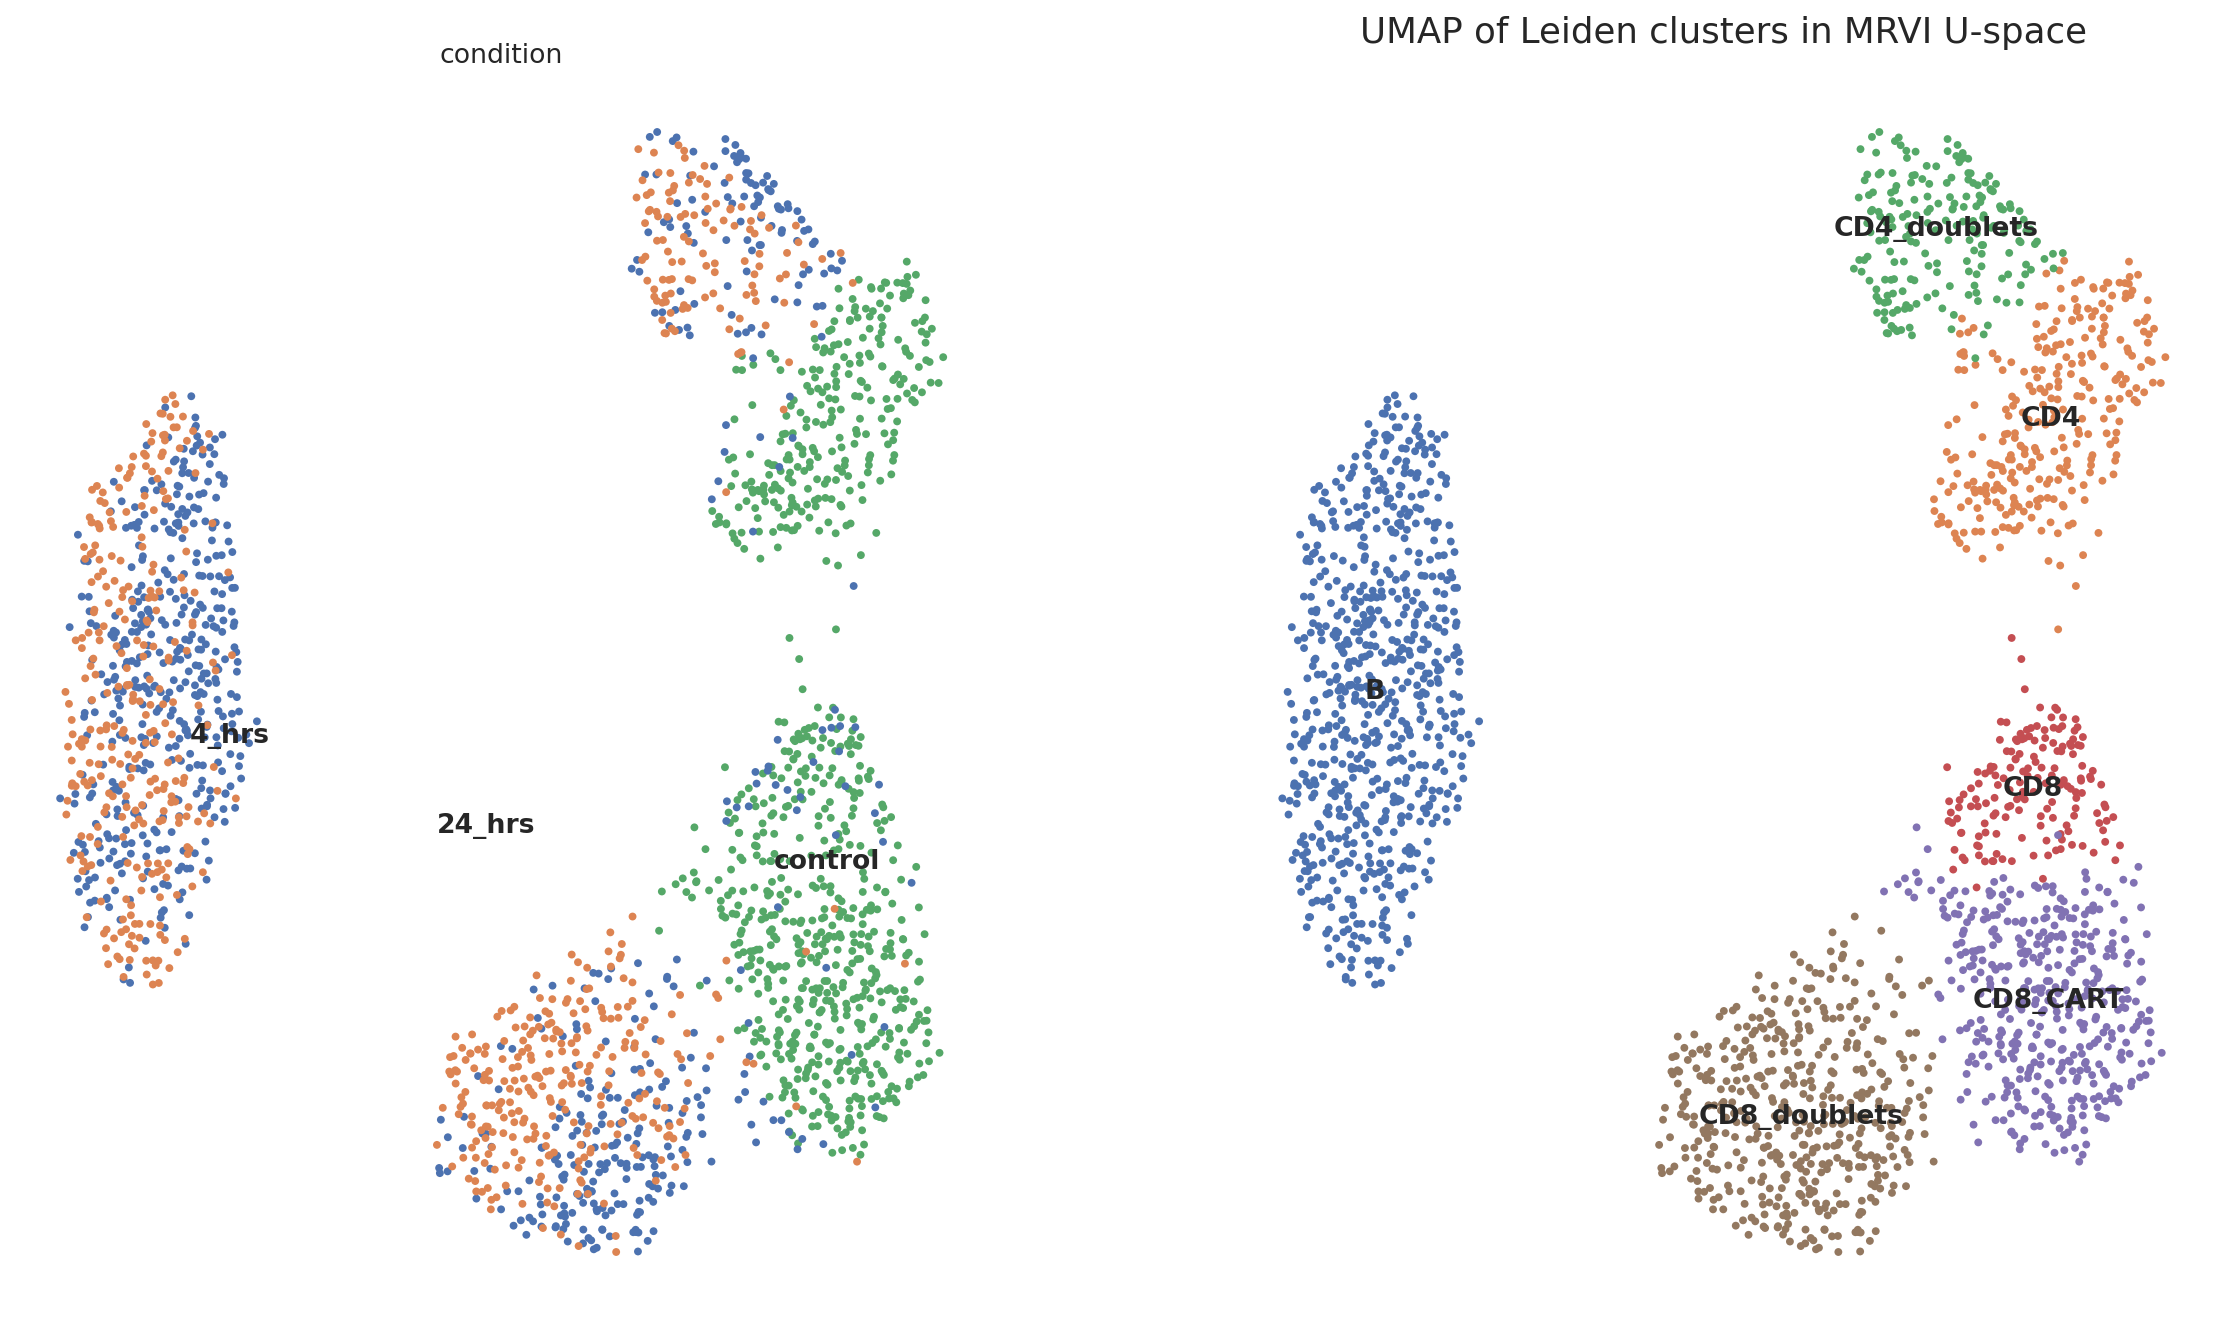

In [122]:
sc.pl.umap(adata, color=["condition",'cell_type'], legend_loc='on data',frameon=False, size=50, show=False)
plt.gcf().set_size_inches(18, 10)
plt.title("UMAP of Leiden clusters in MRVI U-space", fontsize=16, pad=15)
plt.show()

# SPATIAL

In [123]:
adata

AnnData object with n_obs × n_vars = 2253 × 159
    obs: 'n_umi1', 'n_umi2', 'n_edges', 'n_antibodies', 'reads_in_component', 'n_umi', 'isotype_fraction', 'intracellular_fraction', 'sample', 'antibodies', 'average_k_core', 'k_core_1', 'k_core_2', 'k_core_3', 'run', 'condition', 'sample_name', 'leiden', '_scvi_batch', '_scvi_labels', 'cell_type'
    var: 'antibody_count', 'antibody_pct', 'components', 'control', 'nuclear'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'condition_colors', 'leiden', 'leiden_colors', 'neighbors', 'run_colors', 'umap', 'cell_type_colors'
    obsm: 'HOTSPOT', 'HOTSPOT_top500_var', 'X_umap', 'clr', 'log1p', 'pca', 'spatial_arcsinh_top500_var', 'spatial_asinh', 'spatial_quantile', 'spatial_raw', 'spatial_tanh4', 'z_abundance_only', 'z_joint_encoders_MOE_HOTSPOT', 'z_joint_encoders_POE_HOTSPOT', 'z_single_encoders_HOTSPOT', 'arcsinh'
    layers: 'arcsinh', 'clr', 'counts', 'log1p'
    obsp: 'connectivities', 'distances'

In [141]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='HOTSPOT_top500_var')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.8)



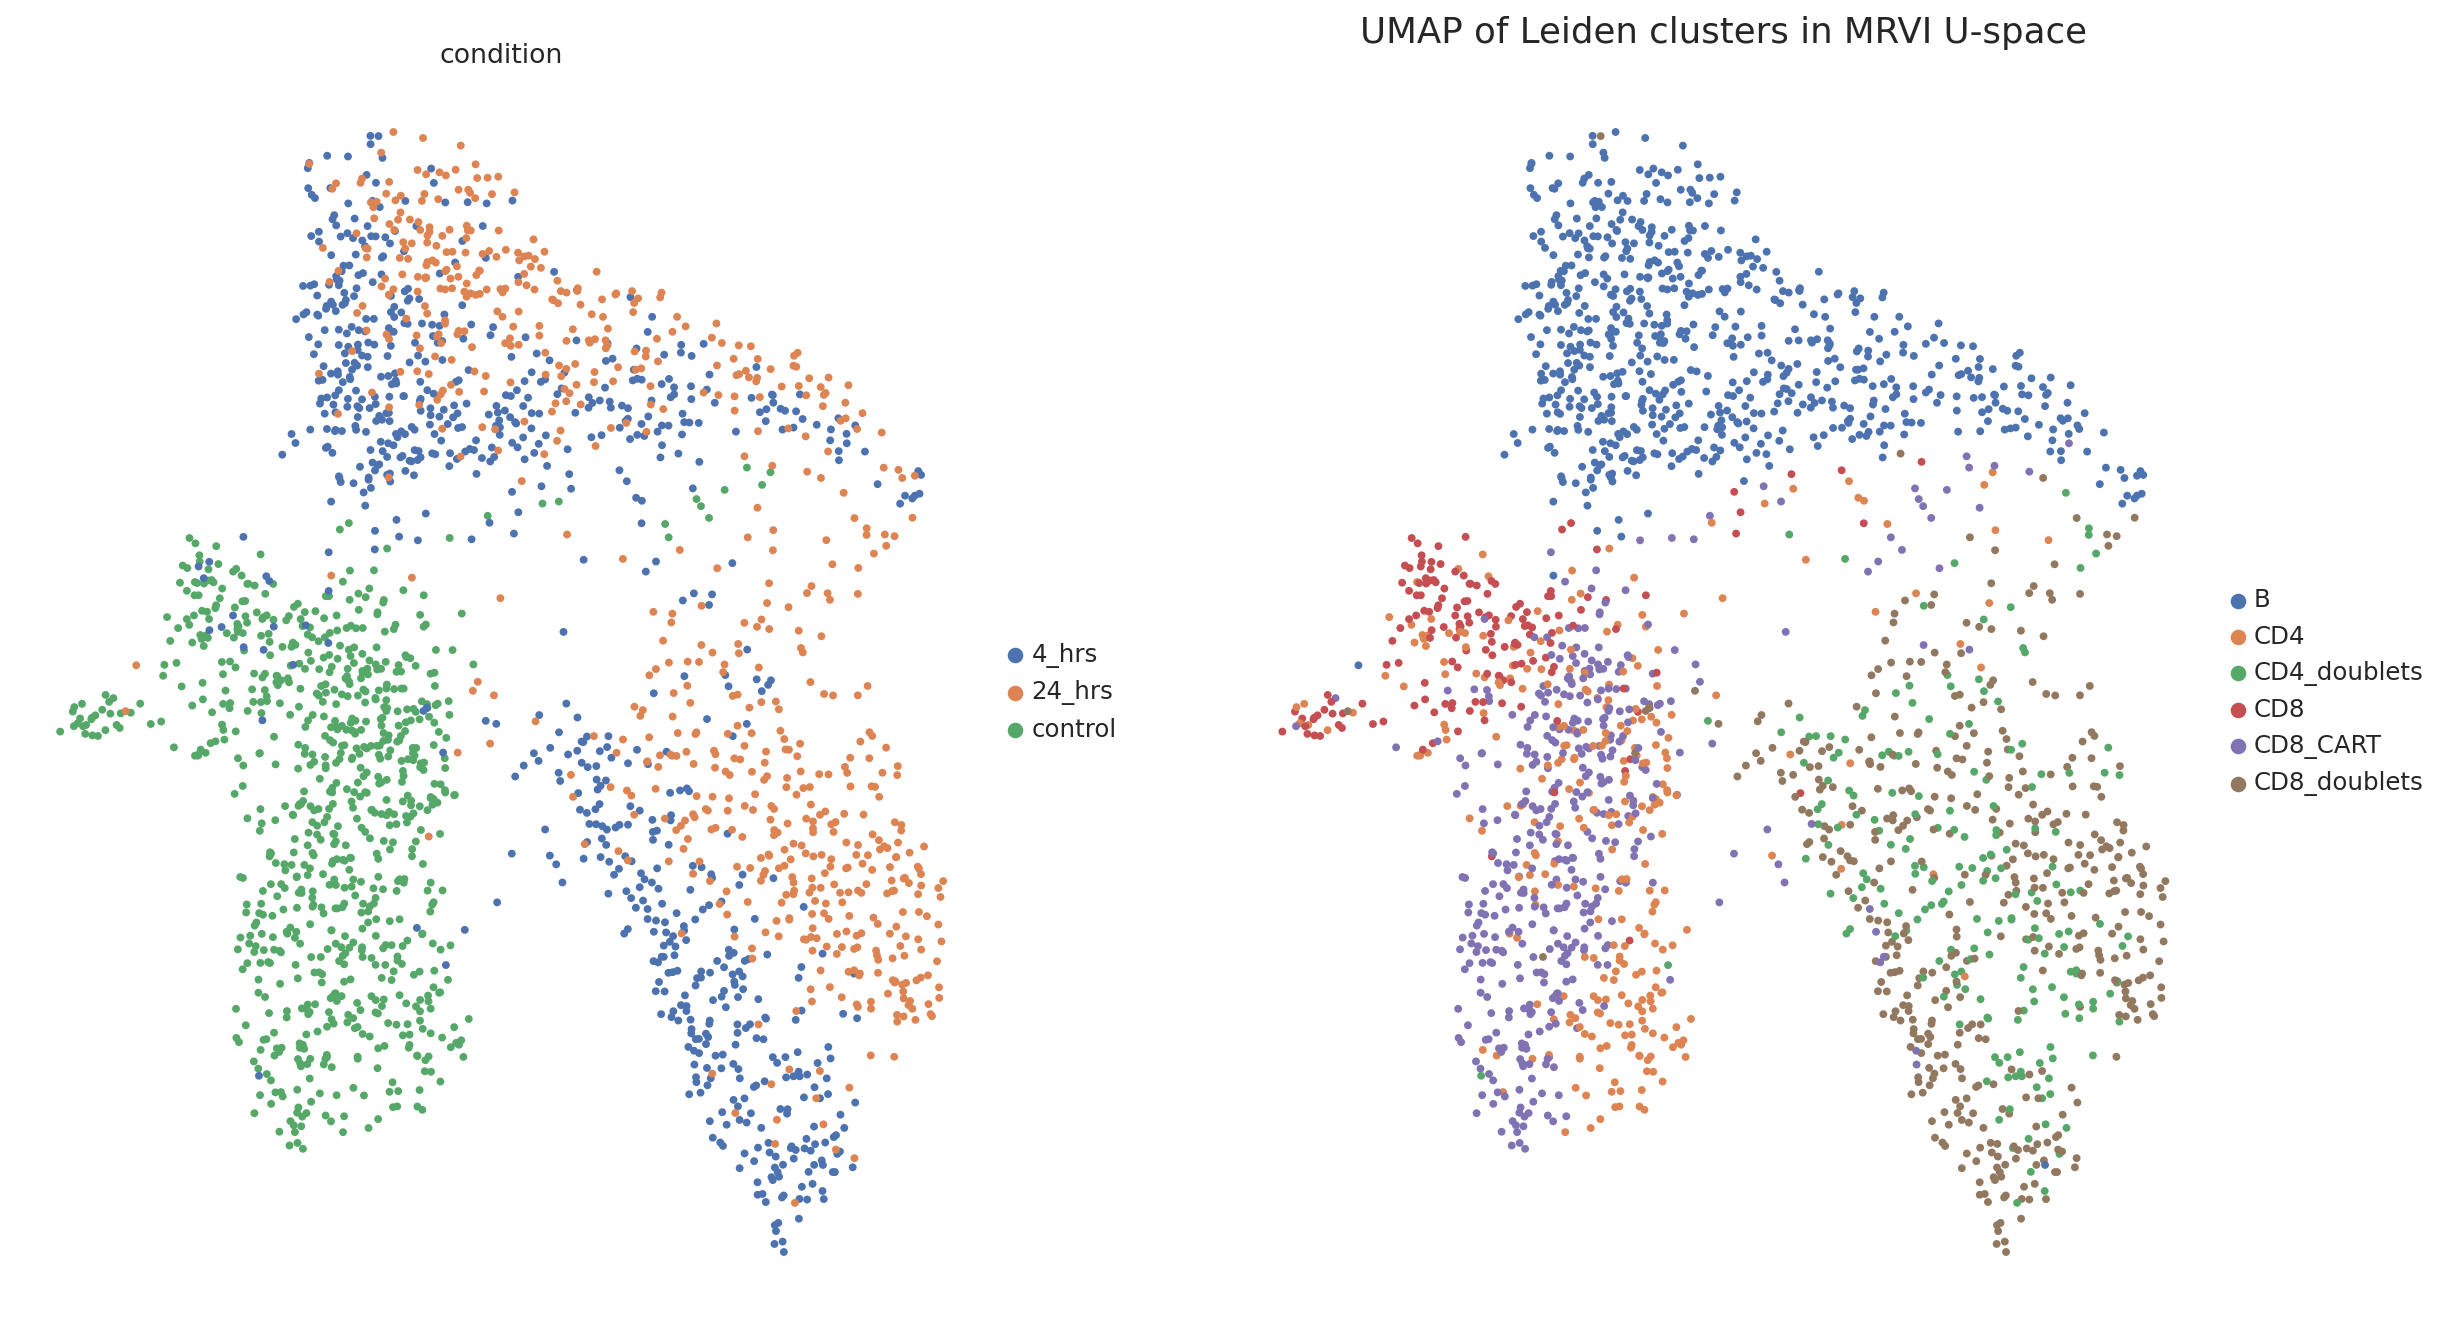

In [142]:
sc.pl.umap(adata, color=["condition",'cell_type'], frameon=False, size=50, show=False)
plt.gcf().set_size_inches(18, 10)
plt.title("UMAP of Leiden clusters in MRVI U-space", fontsize=16, pad=15)
plt.show()

# POE LATENTS

In [129]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='z_joint_encoders_POE_HOTSPOT')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.8)


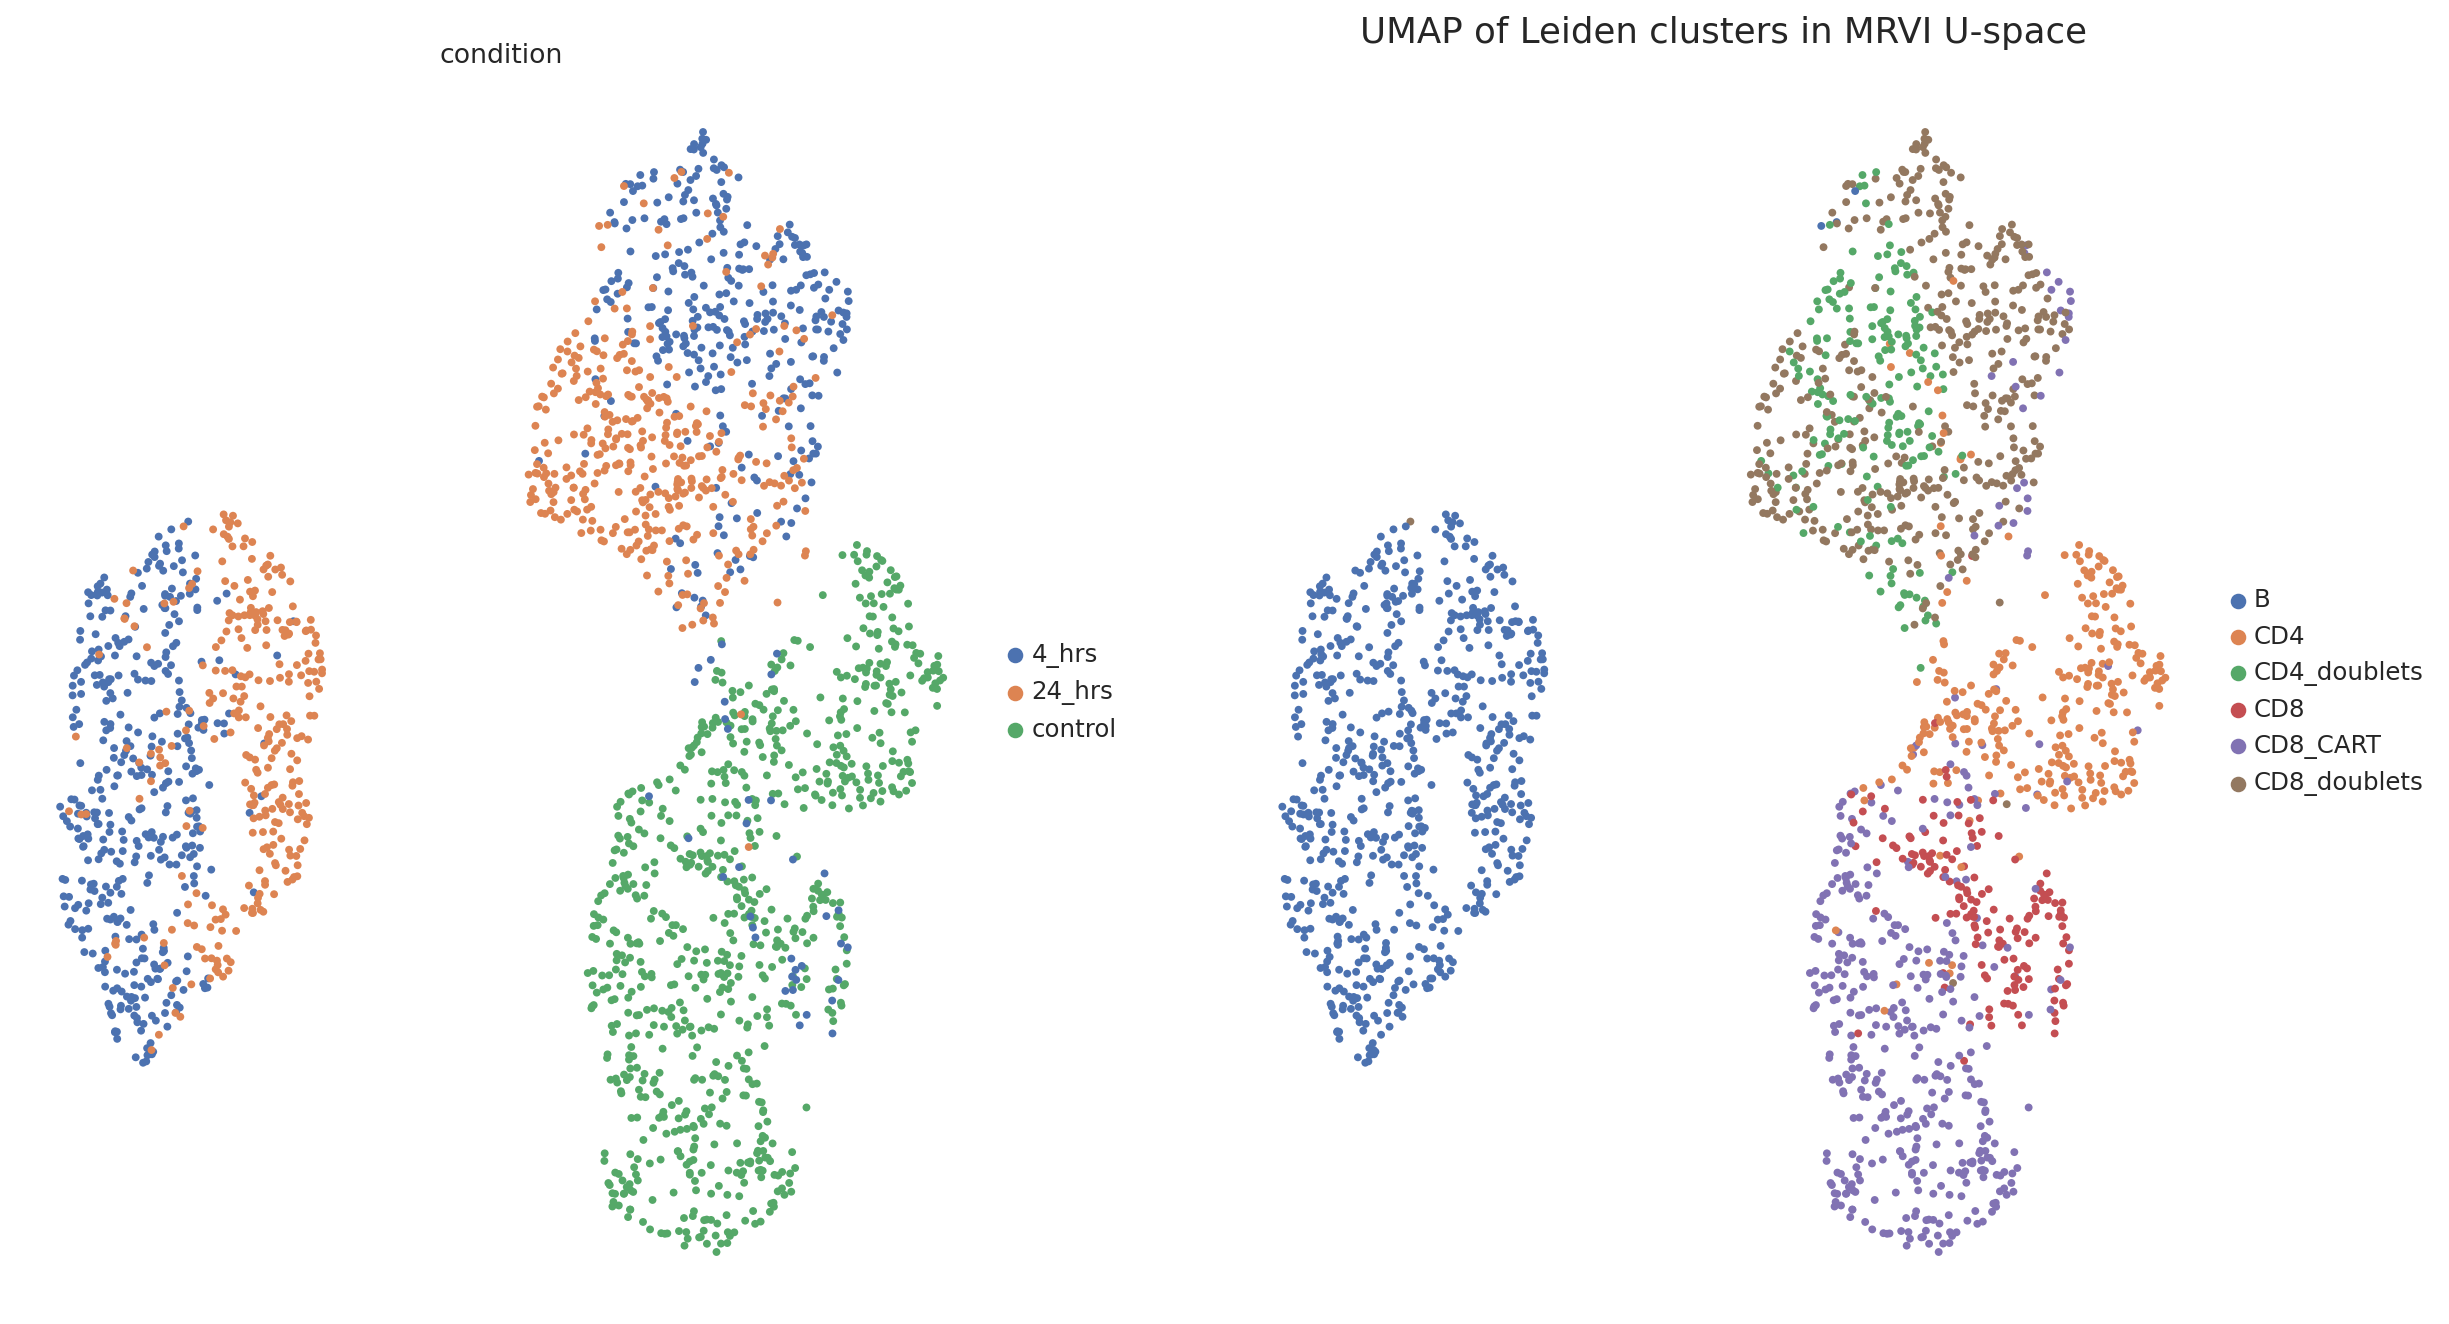

In [132]:
sc.pl.umap(adata, color=["condition",'cell_type'], frameon=False, size=50, show=False)
plt.gcf().set_size_inches(18, 10)
plt.title("UMAP of Leiden clusters in MRVI U-space", fontsize=16, pad=15)
plt.show()

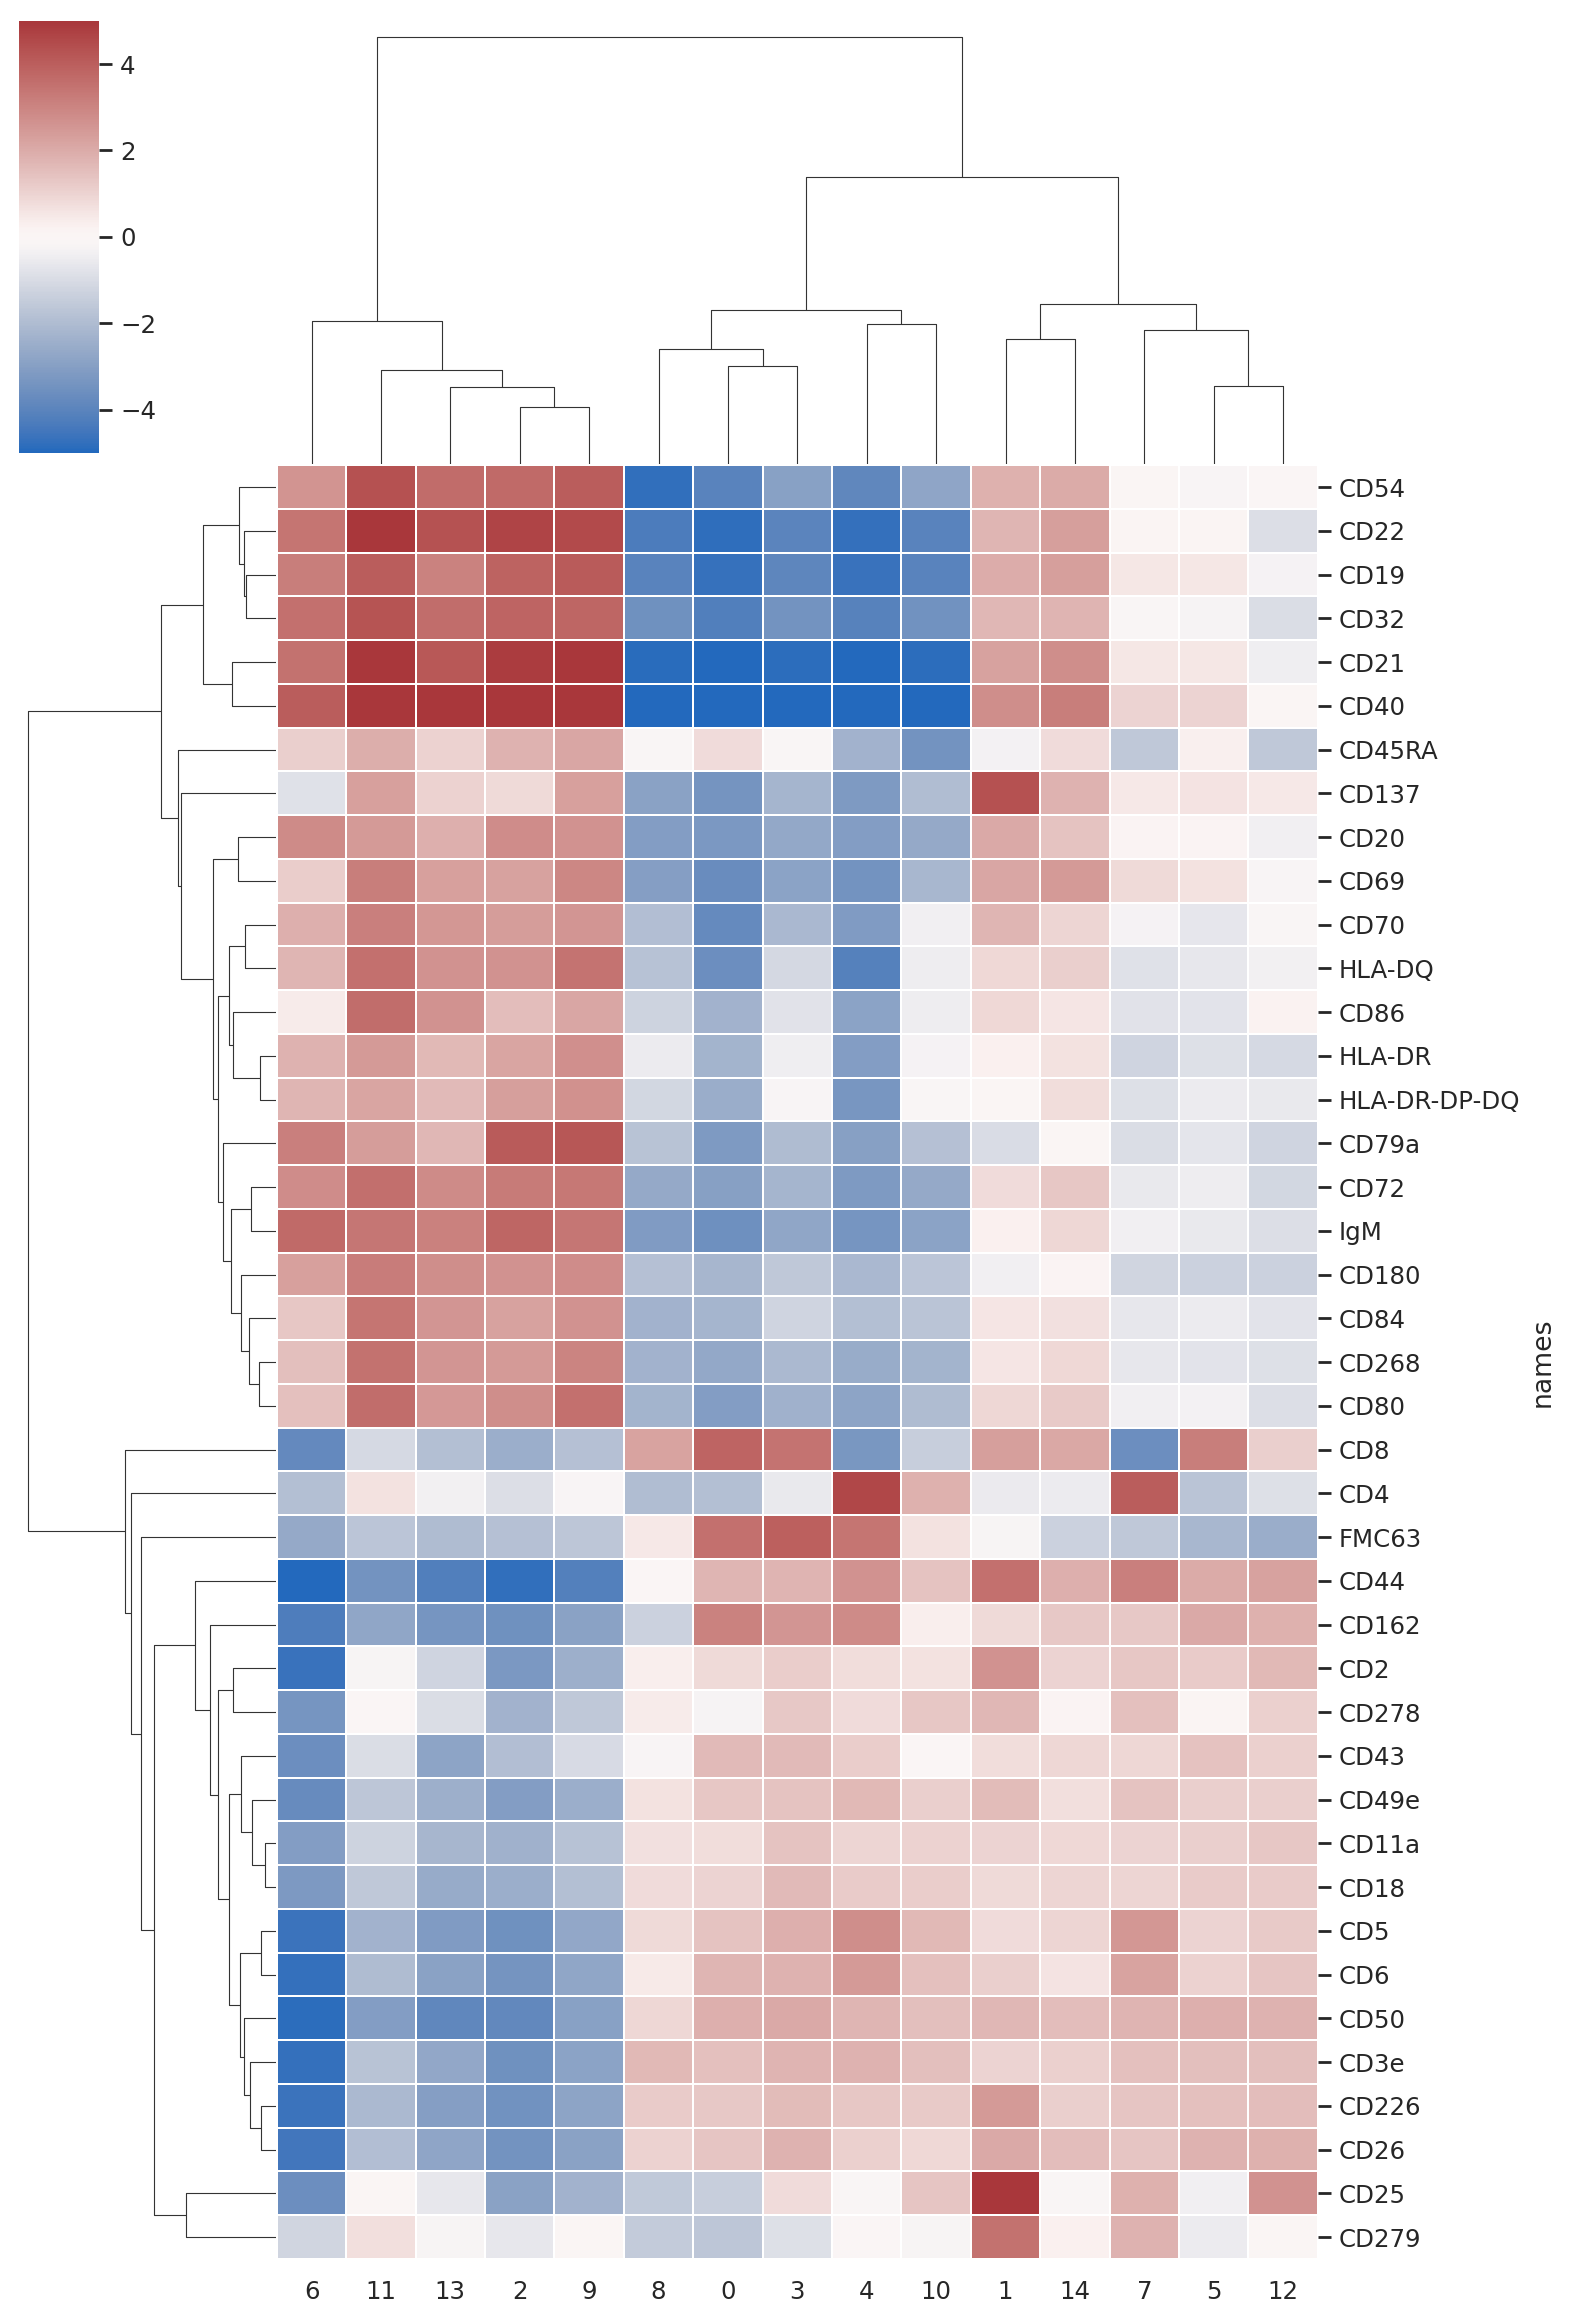

In [133]:
adata_tmp = ad.AnnData(
    X=adata.layers['log1p'],
    obs=adata.obs.copy(), var=adata.var.copy()
)
sc.tl.rank_genes_groups(adata_tmp,'leiden', method="wilcoxon",)


diff_exp_df = sc.get.rank_genes_groups_df(adata_tmp, group=None)
diff_exp_df["-log10(adjusted p-value)"] = -np.log10(diff_exp_df["pvals_adj"])
diff_exp_df["Significant"] = diff_exp_df["pvals_adj"] < 0.01
df = diff_exp_df.pivot(index=["names"], columns=["group"], values=["logfoldchanges"])

markers_for_heatmap = set(
    diff_exp_df[
        (np.abs(diff_exp_df["logfoldchanges"]) > 3) & diff_exp_df["Significant"]
    ]["names"]
)
markers_to_add=[]

markers_for_heatmap.update(markers_to_add)

df = df[df.index.isin(markers_for_heatmap)]

df.columns = [cluster for _, cluster in df.columns]
fig = sns.clustermap(df, yticklabels=True, linewidths=0.1, cmap="vlag", vmin=-5, vmax=5);
fig.fig.set_size_inches(10, 15)

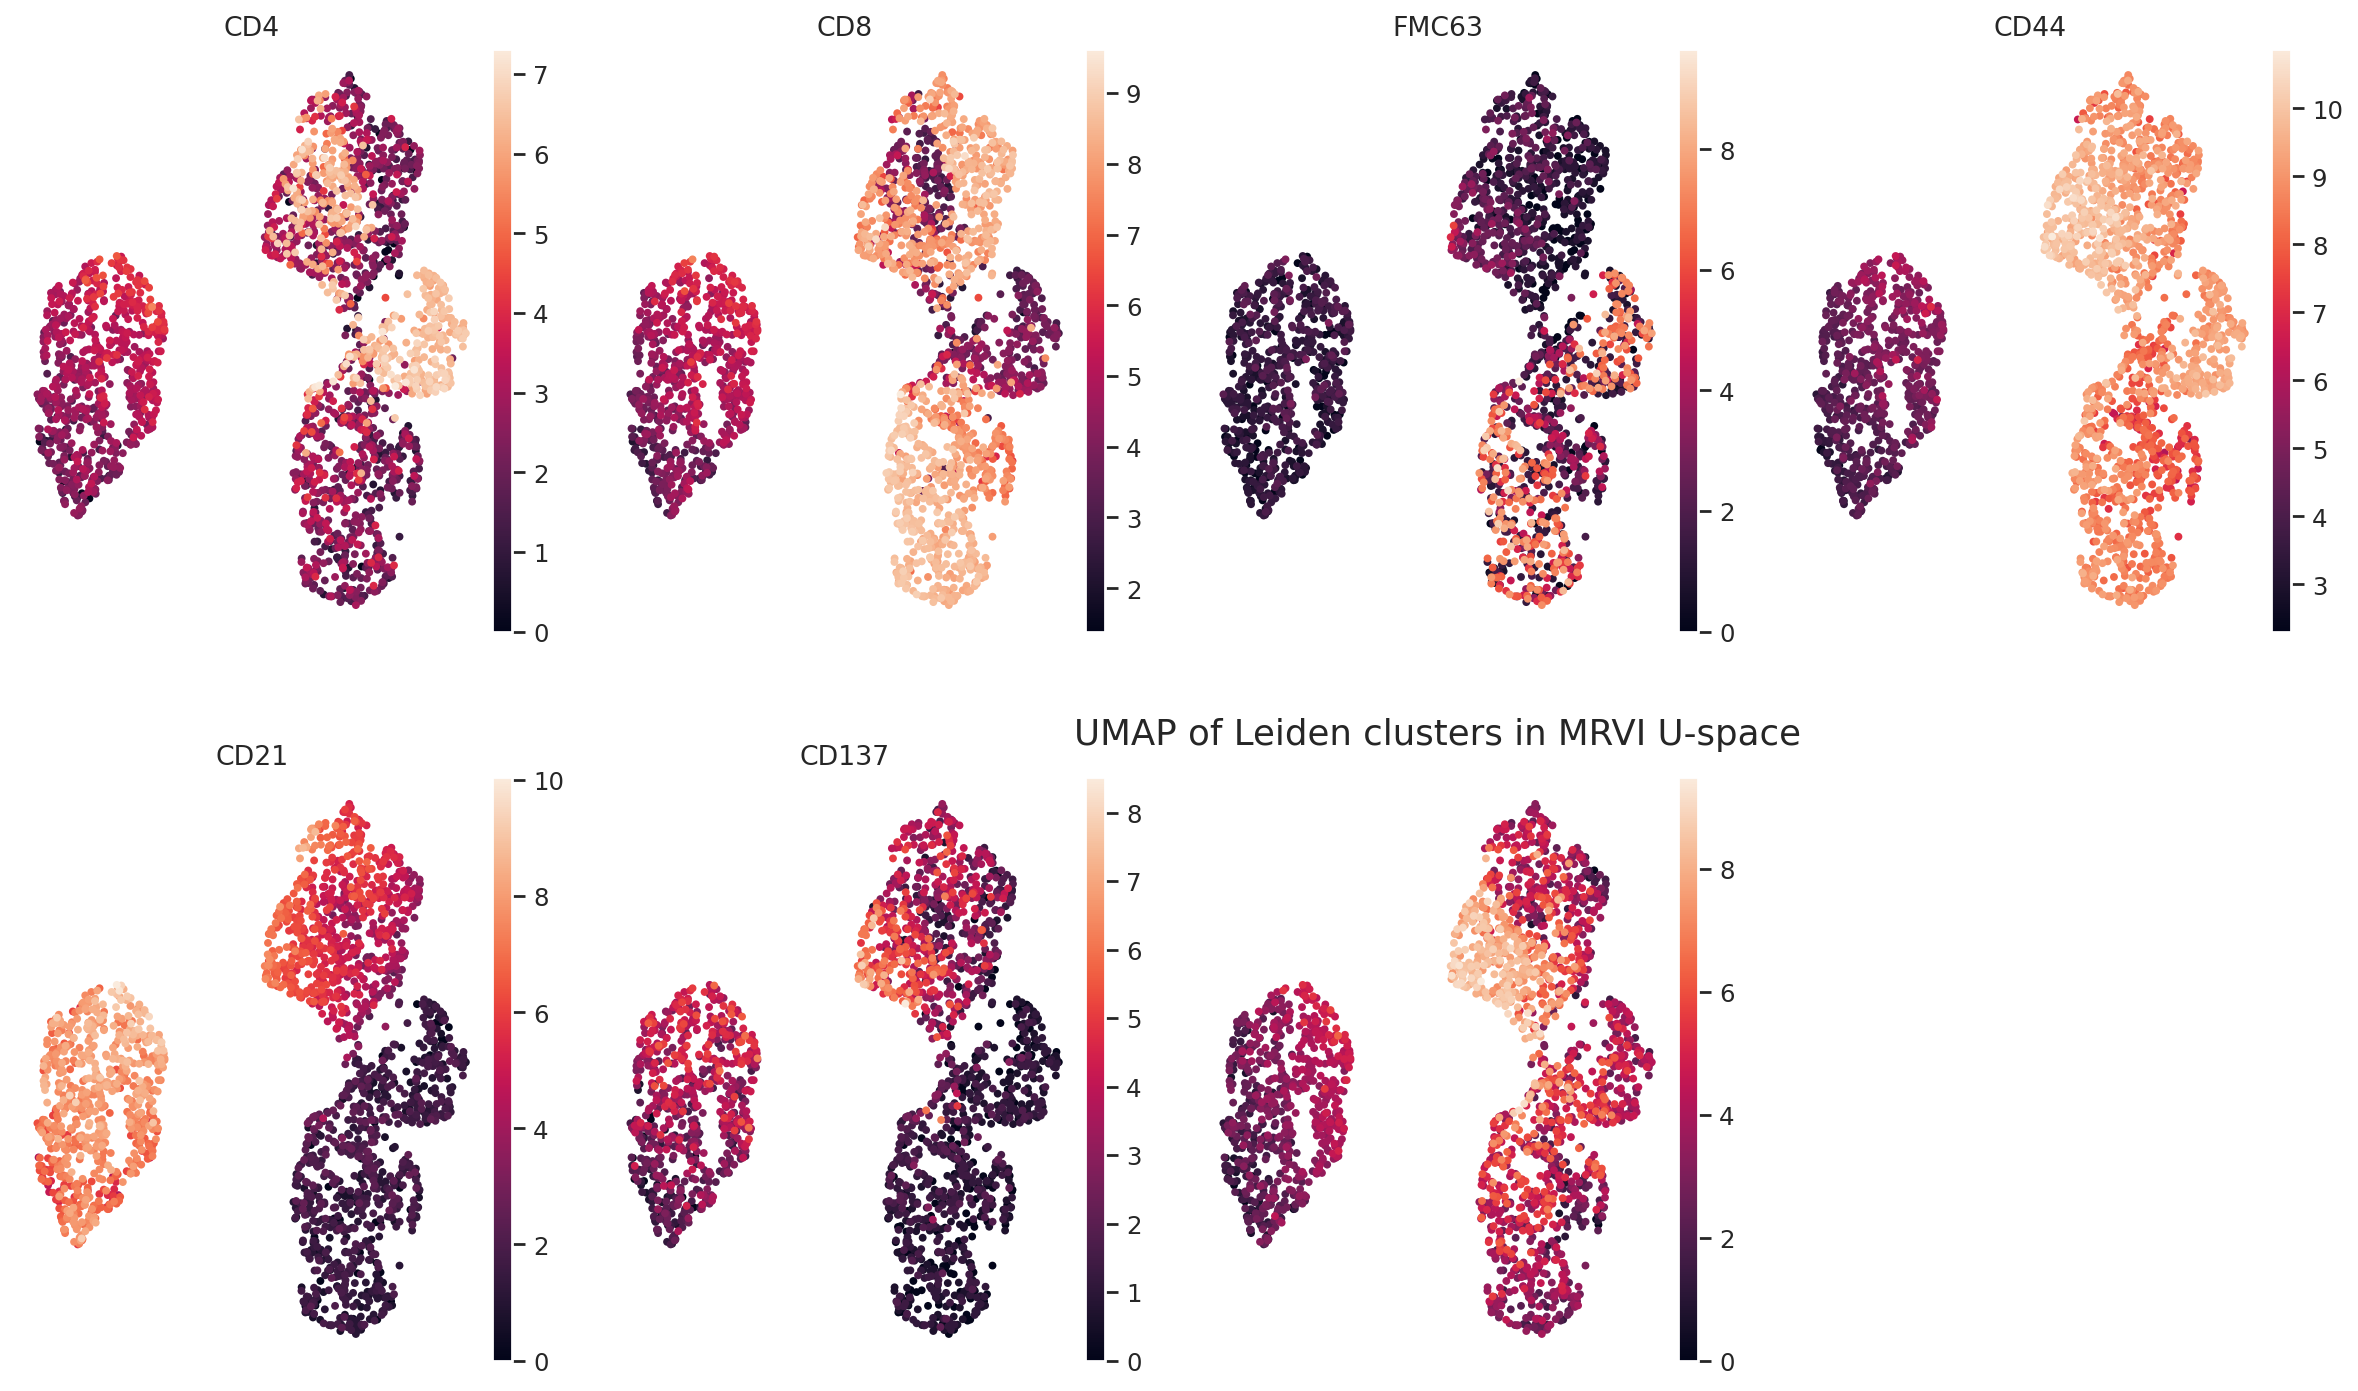

In [136]:
rel_genes=['CD4','CD8','FMC63','CD44','CD21','CD137','CD25']

sc.pl.umap(adata, color=rel_genes, frameon=False, size=50, show=False,layer='log1p')
plt.gcf().set_size_inches(18, 10)
plt.title("UMAP of Leiden clusters in MRVI U-space", fontsize=16, pad=15)
plt.show()